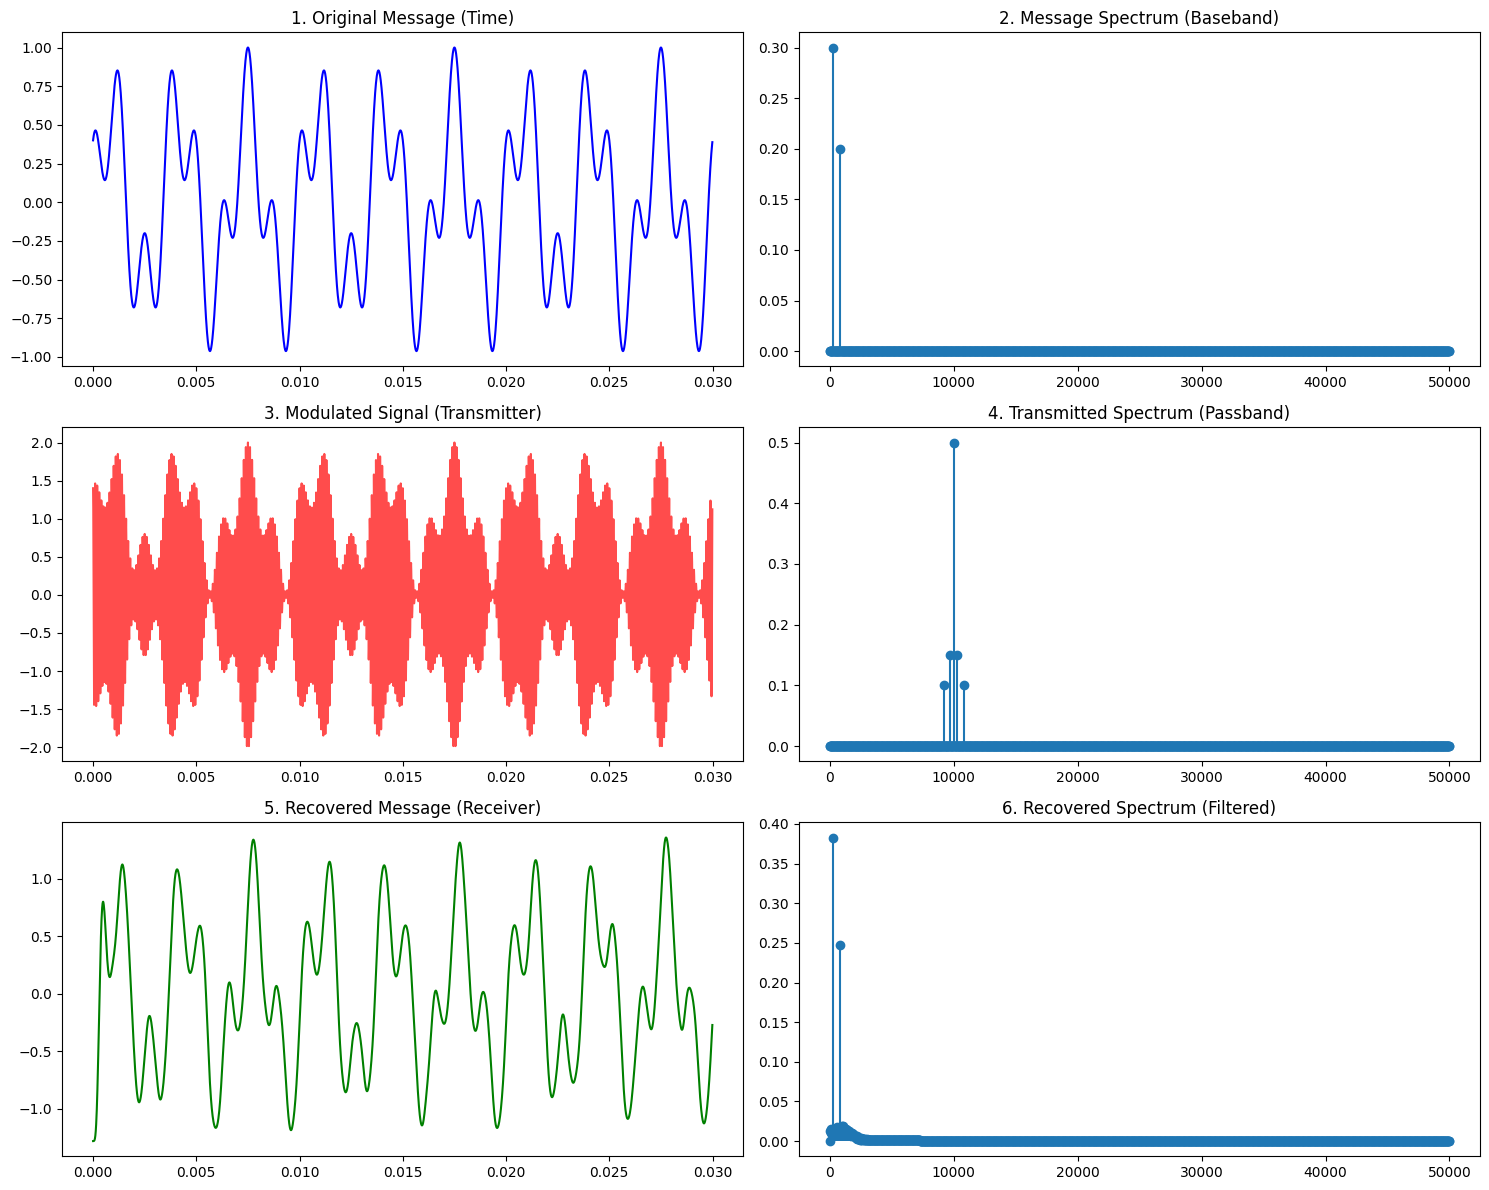

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

# 1. Setup Parameters
fs = 100000                     # High sampling rate for smooth filtering
t = np.arange(0, 0.03, 1/fs)    # 30ms simulation
fc = 10000                      # 10kHz Carrier

# --- TRANSMITTER ---
# Message: Multi-tone voice simulation
m_t = 0.6 * np.sin(2 * np.pi * 300 * t) + 0.4 * np.cos(2 * np.pi * 800 * t)
# Modulation (AM-DSB-WC: Double Sideband With Carrier)
carrier = np.cos(2 * np.pi * fc * t)
s_t_tx = (1 + m_t) * carrier

# --- CHANNEL ---
# Adding White Gaussian Noise (AWGN)
noise = np.random.normal(0, 0.1, len(t))
s_t_rx = s_t_tx + noise

# --- RECEIVER (Envelope Detection) ---
# A. Rectification (The "Diode" step)
rectified = np.abs(s_t_rx)

# B. Low-Pass Filtering (The "RC Filter" step)
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

b, a = butter_lowpass(cutoff=2000, fs=fs) # Filter out the 10kHz carrier
demodulated = lfilter(b, a, rectified)
# Remove DC offset (the "1" we added during modulation)
recovered_msg = (demodulated - np.mean(demodulated)) * 2

# --- FREQUENCY ANALYSIS ---
def get_spectrum(sig):
    n = len(sig)
    f = np.fft.fftfreq(n, 1/fs)
    mag = np.abs(np.fft.fft(sig) / n)
    return f[:n//2], mag[:n//2]

# --- PLOTTING THE CHAIN ---
fig, axs = plt.subplots(3, 2, figsize=(15, 12))

# 1. Original Message
f_m, m_m = get_spectrum(m_t)
axs[0, 0].plot(t, m_t, color='blue')
axs[0, 0].set_title("1. Original Message (Time)")
axs[0, 1].stem(f_m[:2000], m_m[:2000], basefmt=" ")
axs[0, 1].set_title("2. Message Spectrum (Baseband)")

# 2. Transmitted Signal
f_tx, m_tx = get_spectrum(s_t_tx)
axs[1, 0].plot(t, s_t_tx, color='red', alpha=0.7)
axs[1, 0].set_title("3. Modulated Signal (Transmitter)")
axs[1, 1].stem(f_tx[:15000], m_tx[:15000], basefmt=" ")
axs[1, 1].set_title("4. Transmitted Spectrum (Passband)")

# 3. Recovered Signal
f_rx, m_rx = get_spectrum(recovered_msg)
axs[2, 0].plot(t, recovered_msg, color='green')
axs[2, 0].set_title("5. Recovered Message (Receiver)")
axs[2, 1].stem(f_rx[:2000], m_rx[:2000], basefmt=" ")
axs[2, 1].set_title("6. Recovered Spectrum (Filtered)")

plt.tight_layout()
plt.show()